# Pareto Frontiers for Toggling, Adjoint, and Universal Robustness Objectives (Robustness & Fidelity Trade-off)


## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
# Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using NamedTrajectories
using Statistics
using CairoMakie
using Random
using ColorSchemes
using Makie
using Printf

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651


In [2]:
# Problem parameters
T = 20
Δt = 0.2
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
a_bound = 3.0
sys = QuantumSystem(H_drive)

∂ₑHₐ = [PAULIS.X, PAULIS.Y, PAULIS.Z]
var_sys = VariationalQuantumSystem(
    H_drive,
    ∂ₑHₐ
)


VariationalQuantumSystem: levels = 2, n_drives = 3

In [3]:
propertynames(sys.H)
sys.H.H_drift

2×2 SparseMatrixCSC{ComplexF64, Int64} with 0 stored entries:
     ⋅          ⋅    
     ⋅          ⋅    

In [4]:
function SpaceCurve(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
    T = traj.T
    first_order_terms = Vector{Matrix{ComplexF64}}(undef, T)
    first_order_integral = zeros(ComplexF64, size(U_goal))

    for i in 1:T
        U = iso_vec_to_operator(traj.Ũ⃗[:, i])
        first_order_integral += U' * H_err * U
        first_order_terms[i] = first_order_integral
    end
    d = size(U_goal)[1]
    space_curve = [[real(tr(PAULIS.X * first_order_terms[t] / (d * T))),
                    real(tr(PAULIS.Y * first_order_terms[t] / (d * T))),
                    real(tr(PAULIS.Z * first_order_terms[t] / (d * T)))] for t in 1:T] 
    return space_curve
end

function space_curve_robustness(traj::NamedTrajectory, U_goal::AbstractMatrix, H_err::AbstractMatrix)
    curve = SpaceCurve(traj, U_goal, H_err)
    # Use the norm of the final point as a robustness measure
    # (larger values indicate more accumulated error sensitivity)
    final_point = curve[end]
    return norm(final_point)
end

function width_robustness(system::AbstractQuantumSystem, H_err::Function, traj::NamedTrajectory; thresh::Float64=0.999, H_drive_err::Union{Nothing, Matrix{Float64}}=nothing)
    takes = 1
    width = 0.0
    F = 1.0
    drift = system.H.H_drift
    drives = system.H.H_drives
    noisy_drift = drift + H_err
    if isnothing(H_mult)
        noisy_drive = drives + H_drive_err
        noisy_sys = QuantumSystem(noisy_drift, noisy_drive)
    else
        noisy_sys = QuantumSystem(noisy_drift, drives)
    end

    while (takes < 500 && F >= thresh)
        F = unitary_rollout_fidelity(traj, noisy_sys)
        width += takes^(-1)
    end
    return width
end

width_robustness (generic function with 1 method)

In [5]:
ddas = 10 .^ range(-0.4, 0.4, length=20)

20-element Vector{Float64}:
 0.39810717055349726
 0.43863700057795385
 0.4832930238571753
 0.5324953129837531
 0.5867067065993101
 0.6464371632490061
 0.7122485584859914
 0.7847599703514613
 0.8646535029500364
 0.9526807029019819
 1.0496696290308785
 1.1565326417902508
 1.2742749857031337
 1.404004245548316
 1.5469407652461997
 1.7044291274531953
 1.8779508018514914
 2.0691380811147897
 2.279789435643566
 2.51188643150958

### Pareto Frontiers + Penalty Plots

In [6]:
n_guesses = 6
n_drives = sys.n_drives
var_n_drives = var_sys.n_drives
variational_scales = fill(1.0, length(var_sys.G_vars))
seeds = []
n_seeds = n_guesses
n_ddas = length(ddas)

uni_convergence_times = zeros(n_seeds, n_ddas)
var_convergence_times = zeros(n_seeds, n_ddas)
tog_convergence_times = zeros(n_seeds, n_ddas)

ddas = 10 .^ range(-0.4, 0.4, length=20)


default_probs = Matrix{Any}(undef, n_seeds, n_ddas)
var_probs = Matrix{Any}(undef, n_seeds, n_ddas)
tog_probs = Matrix{Any}(undef, n_seeds, n_ddas)
uni_probs = Matrix{Any}(undef, n_seeds, n_ddas)
# ftog_probs= Matrix{Any}(undef, n_seeds, n_ddas)

Hₑ_add = a -> [PAULIS.X, PAULIS.Y, PAULIS.Z]
F = 0.9999

for i in 1:n_seeds
    Random.seed!(124+20*i)
    for (j, dda) in enumerate(ddas)

        # uni problem
        uni_prob = UnitaryUniversalProblem(
            sys, U_goal, T, Δt;
            piccolo_options=piccolo_opts,
            activate_hyperspeed=true,
            R=1e-5,
            a_bound=a_bound,
            dda_bound=dda,
            Q=0.0,
            Q_t=1.0
        )
        push!(uni_prob.constraints, FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, uni_prob.trajectory))
        uni_elapsed_time = @elapsed begin
            solve!(uni_prob, max_iter=750, print_level=5, options=IpoptOptions(eval_hessian=false))
            solve!(uni_prob, max_iter=40, print_level=5)
        end
        uni_convergence_times[i,j] = uni_elapsed_time
        uni_probs[i,j] = uni_prob
    end
end


    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:     2376
Number of nonzeros in inequality constraint Jacobian.:        8
Number of no

Excessive output truncated after 524329 bytes.

In [7]:

for i in 1:n_seeds
    Random.seed!(124+20*i)
    for (j, dda) in enumerate(ddas)
       
        # tog problem
        tog_prob = UnitarySmoothPulseProblem(
            sys, U_goal, T, Δt;
            activate_rob_loss=true,
            H_err=Hₑ_add,
            R=1e-5,
            a_bound=a_bound,
            dda_bound=dda,
            Q=0.0,
            Q_t=1.0,
            piccolo_options=piccolo_opts
        )
        push!(tog_prob.constraints, FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, tog_prob.trajectory))
        tog_elapsed_time = @elapsed begin
            solve!(tog_prob; max_iter=750, print_level=5, options=IpoptOptions(eval_hessian=false))
            solve!(tog_prob; max_iter=40, print_level=5)
        end
        tog_convergence_times[i,j] = tog_elapsed_time
        tog_probs[i, j] = tog_prob 
    end
end

In [8]:

for i in 1:n_seeds
    Random.seed!(124+20*i)
    for (j, dda) in enumerate(ddas)
       
        var_prob = UnitaryVariationalProblem(
            var_sys, U_goal, T, Δt;
            piccolo_options=piccolo_opts,
            Q=0.0,
            a_bound=a_bound,
            dda_bound=dda,
            Q_r=1.0,
            R=1e-5
        )
        push!(var_prob.constraints, FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, var_prob.trajectory))
        var_elapsed_time = @elapsed begin
            solve!(var_prob; max_iter=750, print_level=5, options=IpoptOptions(eval_hessian=false))
            solve!(var_prob; max_iter=40, print_level=5)
        end
        var_convergence_times[i,j] = var_elapsed_time
        var_probs[i, j] = var_prob
    end
end

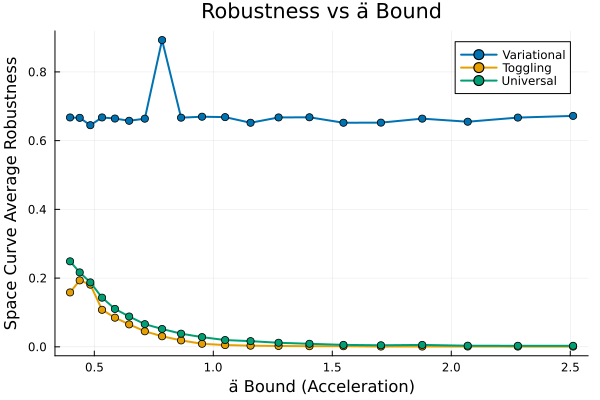

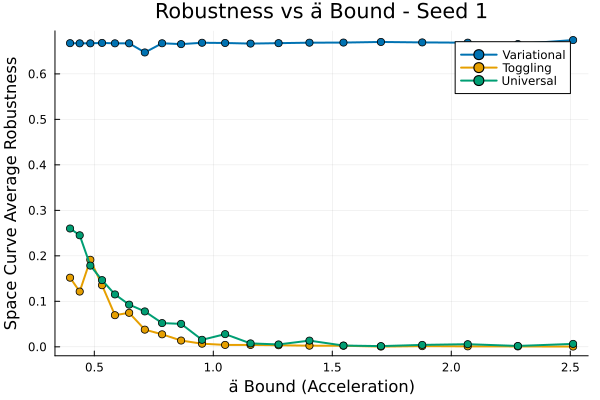

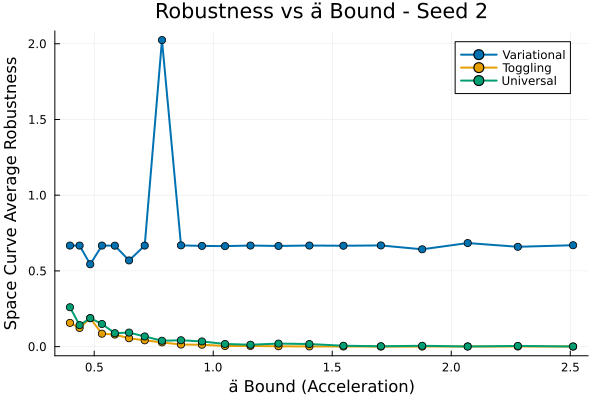

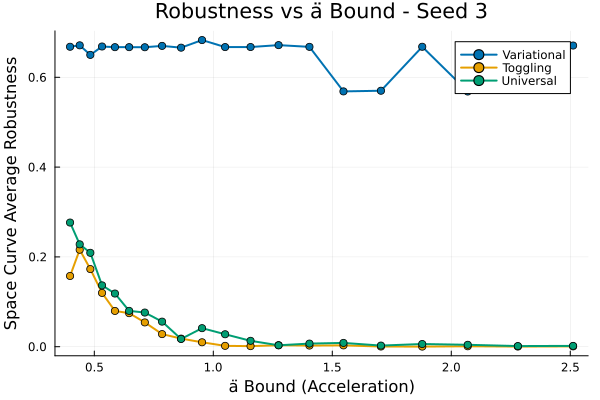

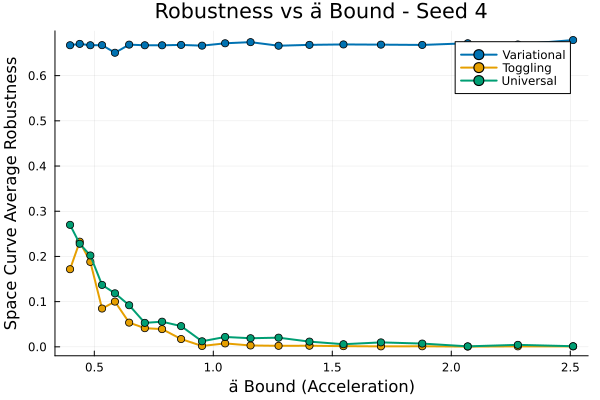

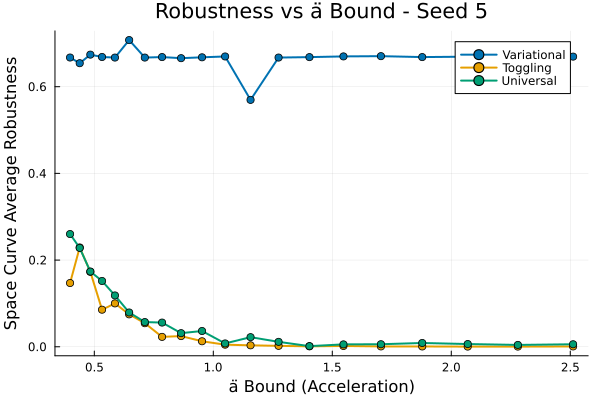

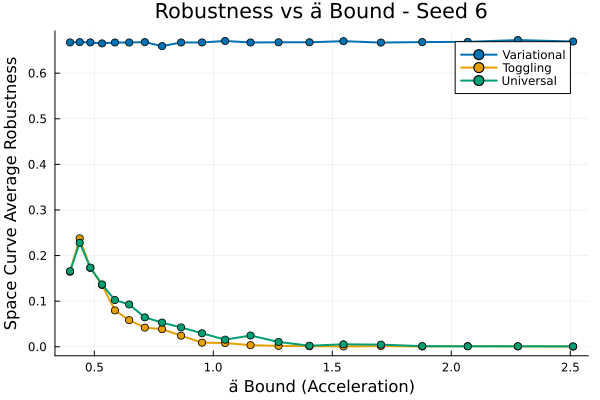

In [9]:
# Updated plotting code for robustness vs dda_bound
arr_probs = [var_probs, tog_probs, uni_probs]
method_names = ["Variational", "Toggling", "Universal"]
method_colors = Makie.wong_colors()


# Create the main plot
plt = Plots.plot(
    xlabel="ä Bound (Acceleration)",
    ylabel="Space Curve Average Robustness",
    title="Robustness vs ä Bound",
    legend=:topright, 
    grid=true,
    linewidth=2,
    markersize=4
)

# Plot each method
for (prob_idx, probs) in enumerate(arr_probs)
    method_name = method_names[prob_idx]
    method_color = method_colors[prob_idx]
    
    # Average over seeds for each dda value
    avg_robustness_per_dda = Float64[]
    
    for (j, dda) in enumerate(ddas)
        seed_robustness = Float64[]
        
        for s in 1:n_seeds
            prob = probs[s, j]
            
            # Compute robustness using space curve for each Pauli direction
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            
            push!(seed_robustness, avg_robustness)
        end
        
        # Average across seeds
        push!(avg_robustness_per_dda, mean(seed_robustness))
    end
    
    # Plot this method
    Plots.plot!(plt, ddas, avg_robustness_per_dda, 
               marker=:circle, 
               label=method_name, 
               color=method_color,
               linewidth=2,
               markersize=4)
end

display(plt)

# Optional: Create individual plots for each seed
for s in 1:n_seeds
    plt_seed = Plots.plot(
        xlabel="ä Bound (Acceleration)",
        ylabel="Space Curve Average Robustness",
        title="Robustness vs ä Bound - Seed $s",
        legend=:topright, 
        grid=true,
        linewidth=2,
        markersize=4
    )
    
    for (prob_idx, probs) in enumerate(arr_probs)
        method_name = method_names[prob_idx]
        method_color = method_colors[prob_idx]
        
        robustness_per_dda = Float64[]
        
        for (j, dda) in enumerate(ddas)
            prob = probs[s, j]
            
            # Compute robustness using space curve
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            
            push!(robustness_per_dda, avg_robustness)
        end
        
        Plots.plot!(plt_seed, ddas, robustness_per_dda, 
                   marker=:circle, 
                   label=method_name, 
                   color=method_color,
                   linewidth=2,
                   markersize=4)
    end
    
    display(plt_seed)
end

Initial Fidelity Summary Table

In [10]:
# for seed_idx in 1:n_seeds
#     display("\nseed idx = $seed_idx:")
#     display("Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Fast Toggle Fidelity | Universal Fidelity | ")
#     display("-" ^ 40)
#     for (j, ä) in enumerate(n_ddas)
#             def_fid = unitary_rollout_fidelity(default_probs[seed_idx, j].trajectory, sys)
#             var_fid = unitary_rollout_fidelity(var_probs[seed_idx, j].trajectory, sys)
#             tog_fid = unitary_rollout_fidelity(tog_probs[seed_idx, j].trajectory, sys)
#             ftog_fid = unitary_rollout_fidelity(ftog_probs[seed_idx, j].trajectory, sys)
#             uni_fid = unitary_rollout_fidelity(uni_probs[seed_idx, j].trajectory, sys)
#             display("$(lpad(round(ä, digits=6), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(var_fid, digits=6), 12)) | $(lpad(round(tog_fid, digits=6), 13))  | $(lpad(round(ftog_fid, digits=6), 13)) | $(lpad(round(uni_fid, digits=6), 13)) |")
#     end
# end

"\nseed idx = 1:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Fast Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

UndefRefError: UndefRefError: access to undefined reference

Pareto Frontiers

Penalty

In [11]:
sweep_rob_loss_λ = exp.(range(log(.1), log(100), length=8))


8-element Vector{Float64}:
   0.10000000000000002
   0.26826957952797265
   0.7196856730011523
   1.9306977288832508
   5.1794746792312125
  13.894954943731383
  37.27593720314942
 100.00000000000004

In [12]:
n_ddas = length(ddas)

pen_var_probs = Matrix{Any}(undef, n_seeds, n_ddas)
pen_tog_probs = Matrix{Any}(undef, n_seeds, n_ddas)
pen_uni_probs = Matrix{Any}(undef, n_seeds, n_ddas)
# pen_ftog_probs= Matrix{Any}(undef, n_seeds, n_ddas)
puni_convergence_times = zeros(n_seeds, n_ddas)
pvar_convergence_times = zeros(n_seeds, n_ddas)
ptog_convergence_times = zeros(n_seeds, n_ddas)

Hₑ_add = a -> [PAULIS.X, PAULIS.Y, PAULIS.Z]
X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive
R_a=1e-5
R_da=1e-5

# for i in 1:n_seeds
#     Random.seed!(124+20*i)
#     for (j, dda) in enumerate(ddas)
#         #fast tog
#         # ftog_prob = UnitarySmoothPulseProblem(
#         #     sys, U_goal, T, Δt;
#         #     piccolo_options=piccolo_opts,
#         #     activate_rob_loss=true,
#         #     H_err=Hₑ_add,
#         #     Q=0.0,
#         #     R_a=R_a,
#         #     R_da=R_da,
#         #     R_dda=dda,
#         #     Q_t=dda
#         # )
#         # push!(ftog_prob.constraints, FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, ftog_prob.trajectory))
#         # solve!(ftog_prob; max_iter=750, print_level=5, options=IpoptOptions(eval_hessian=false))
#         # solve!(ftog_prob; max_iter=150, print_level=5)
#         # pen_ftog_probs[i, j] = ftog_prob
#     end
# end

1.0e-5

In [13]:
for i in 1:n_seeds
    Random.seed!(124+20*i)
    for (j, dda) in enumerate(ddas)
        R_a=1e-5
        R_da=1e-5
        # var problem
        var_prob = UnitaryVariationalProblem(
            var_sys, U_goal, T, Δt;
            piccolo_options=piccolo_opts,
            Q=0.0,
            a_bound=a_bound,
            R_a=R_a,
            R_da=R_da,
            R_dda=dda,
            Q_r=dda
        )
        push!(var_prob.constraints, FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, var_prob.trajectory))
        elapsed_time = @elapsed begin
            solve!(var_prob; max_iter=750, print_level=5, options=IpoptOptions(eval_hessian=false))
            solve!(var_prob; max_iter=40, print_level=5)
        end
        pen_var_probs[i, j] = var_prob
        pvar_convergence_times[i,j] = elapsed_time
    end
end

In [14]:
for i in 1:n_seeds
    Random.seed!(124+20*i)
    for (j, dda) in enumerate(ddas)
        # uni problem
        uni_prob = UnitaryUniversalProblem(
            sys, U_goal, T, Δt;
            piccolo_options=piccolo_opts,
            activate_hyperspeed=true,
            Q=0.0,
            a_bound=a_bound,
            R_a=R_a,
            R_da=R_da,
            R_dda=dda,
            Q_t=dda
        )
        push!(uni_prob.constraints, FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, uni_prob.trajectory))
        elapsed_time = @elapsed begin
            solve!(uni_prob; max_iter=750, print_level=5, options=IpoptOptions(eval_hessian=false))
            solve!(uni_prob; max_iter=40, print_level=5)
        end
        pen_uni_probs[i, j] = uni_prob
        puni_convergence_times[i,j] = elapsed_time
    end
end


In [15]:
for i in 1:n_seeds
    Random.seed!(124+20*i)
    for (j, dda) in enumerate(ddas)
        # tog problem
        tog_prob = UnitaryToggleProblem(
            sys, U_goal, T, Δt, Hₑ_add;
            piccolo_options=piccolo_opts,
            Q=0.0,
            a_bound=a_bound,
            R_a=R_a,
            R_da=R_da,
            R_dda=dda,
            Q_t=dda
        )
        push!(tog_prob.constraints, FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, tog_prob.trajectory))
        elapsed_time = @elapsed begin
            solve!(tog_prob; max_iter=750, print_level=5, options=IpoptOptions(eval_hessian=false))
            solve!(tog_prob; max_iter=40, print_level=5)
        end
        pen_tog_probs[i, j] = tog_prob
        ptog_convergence_times[i,j] = elapsed_time
    end
end

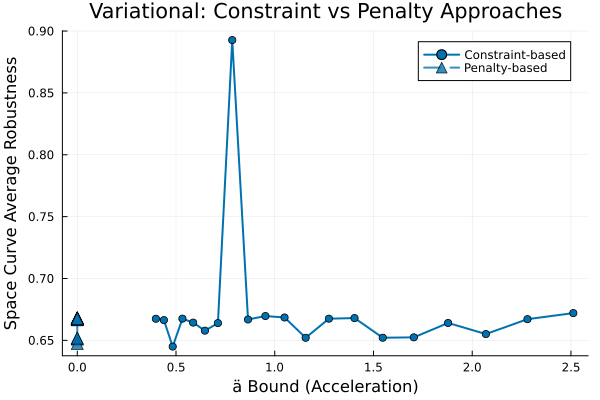

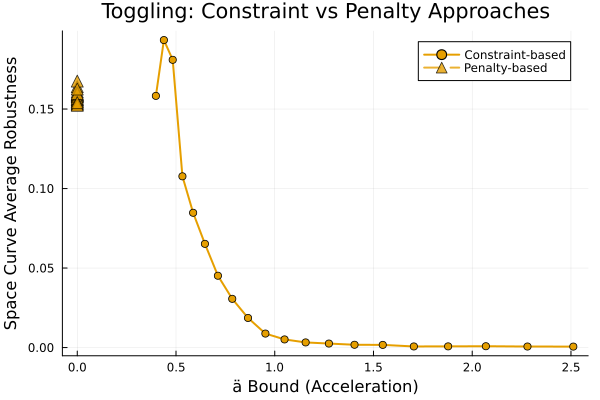

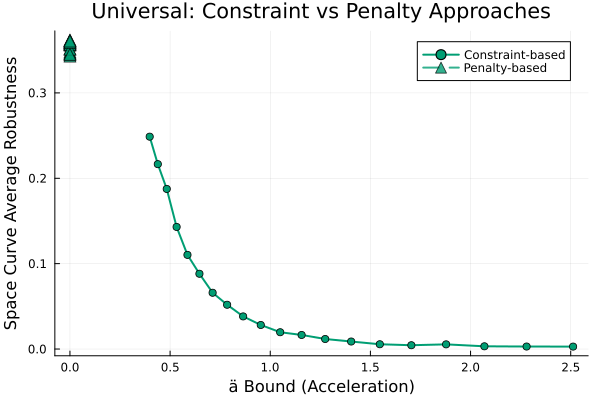

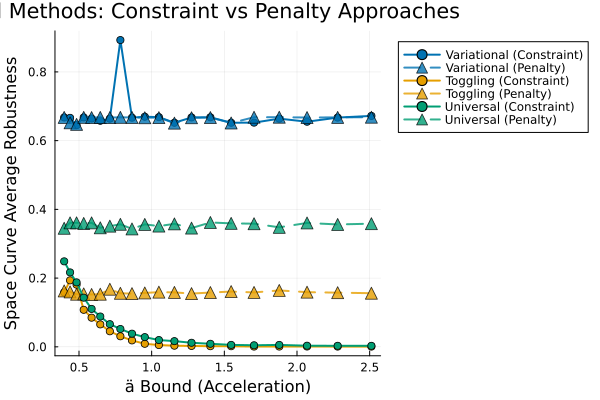

In [20]:
arr_probs = [var_probs, tog_probs, uni_probs]
pen_arr_probs = [pen_var_probs, pen_tog_probs, pen_uni_probs]
method_names = ["Variational", "Toggling", "Universal"]
method_colors = Makie.wong_colors()
ex_prob = tog_probs[1,1]
dims = size(ex_prob.trajectory[:dda])



# Create individual plots for each method showing both constraint and penalty approaches
for (method_idx, method_name) in enumerate(method_names)
    plt_method = Plots.plot(
        xlabel="ä Bound (Acceleration)",
        ylabel="Space Curve Average Robustness",
        title="$method_name: Constraint vs Penalty Approaches",
        legend=:topright, 
        grid=true,
        linewidth=2,
        markersize=4
    )
    
    method_color = method_colors[method_idx]
    
    # Plot constraint-based approach
    probs = arr_probs[method_idx]
    avg_robustness_per_dda = Float64[]
    
    for (j, dda) in enumerate(ddas)
        seed_robustness = Float64[]
        
        for s in 1:n_seeds
            prob = probs[s, j]
            
            # Compute robustness using space curve for each Pauli direction
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            
            push!(seed_robustness, avg_robustness)
        end
        
        # Average across seeds
        push!(avg_robustness_per_dda, mean(seed_robustness))
    end
    
    # Plot constraint approach
    Plots.plot!(plt_method, ddas, avg_robustness_per_dda, 
               marker=:circle, 
               label="Constraint-based", 
               color=method_color,
               linewidth=2,
               markersize=4)
    
    # Plot penalty-based approach
    pen_probs = pen_arr_probs[method_idx]
    penalty_x = Float64[]
    penalty_y = Float64[]
    
    for (j, dda) in enumerate(ddas)
        seed_robustness = Float64[]
        seed_penalty = Float64[]
        
        for s in 1:n_seeds
            prob = pen_probs[s, j]
            
            # Compute robustness using space curve for each Pauli direction
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            
            push!(seed_robustness, avg_robustness)

            dda = mean(norm(prob.trajectory[:dda][:,dims[2]]))
            push!(seed_penalty, dda)
        end
        
        avg_robustness = mean(seed_robustness)
        
        # Effective acceleration Bound
        
        effective_accel_bound = mean(seed_penalty)
        
        push!(penalty_x, effective_accel_bound)
        push!(penalty_y, avg_robustness)
    end
    
    # Sort penalty points by x-axis for smooth line
    sort_idx = sortperm(penalty_x)
    penalty_x_sorted = penalty_x[sort_idx]
    penalty_y_sorted = penalty_y[sort_idx]
    
    # Plot penalty points as triangles with connecting line
    Plots.plot!(plt_method, penalty_x_sorted, penalty_y_sorted,
               marker=:utriangle,
               label="Penalty-based",
               color=method_color,
               linestyle=:dash,
               linewidth=2,
               markersize=6,
               alpha=0.8)
    
    display(plt_method)
end

# Also create the combined overview plot
plt_combined = Plots.plot(
    xlabel="ä Bound (Acceleration)",
    ylabel="Space Curve Average Robustness",
    title="All Methods: Constraint vs Penalty Approaches",
    legend=:outertopright, 
    grid=true,
    linewidth=2,
    markersize=4
)

# Plot all methods on one plot
for (method_idx, method_name) in enumerate(method_names)
    method_color = method_colors[method_idx]
    
    # Plot constraint-based approach
    probs = arr_probs[method_idx]
    avg_robustness_per_dda = Float64[]
    
    for (j, dda) in enumerate(ddas)
        seed_robustness = Float64[]
        
        for s in 1:n_seeds
            prob = probs[s, j]
            
            # Compute robustness using space curve for each Pauli direction
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            
            push!(seed_robustness, avg_robustness)
        end
        
        push!(avg_robustness_per_dda, mean(seed_robustness))
    end
    
    # Plot constraint approach
    Plots.plot!(plt_combined, ddas, avg_robustness_per_dda, 
               marker=:circle, 
               label="$method_name (Constraint)", 
               color=method_color,
               linewidth=2,
               markersize=4)
    
    # Plot penalty-based approach
    pen_probs = pen_arr_probs[method_idx]
    penalty_x = Float64[]
    penalty_y = Float64[]
    
    for (j, dda) in enumerate(ddas)
        seed_robustness = Float64[]
        
        for s in 1:n_seeds
            prob = pen_probs[s, j]
            
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            
            push!(seed_robustness, avg_robustness)
        end
        
        avg_robustness = mean(seed_robustness)
        effective_accel_bound = dda
        
        push!(penalty_x, effective_accel_bound)
        push!(penalty_y, avg_robustness)
    end
    
    # Sort penalty points
    sort_idx = sortperm(penalty_x)
    penalty_x_sorted = penalty_x[sort_idx]
    penalty_y_sorted = penalty_y[sort_idx]
    
    # Plot penalty approach
    Plots.plot!(plt_combined, penalty_x_sorted, penalty_y_sorted,
               marker=:utriangle,
               label="$method_name (Penalty)",
               color=method_color,
               linestyle=:dash,
               linewidth=2,
               markersize=6,
               alpha=0.8)
end

display(plt_combined)

### Save Traks

In [18]:
using JLD2
using Dates

# Collect trajectories only (lighter than storing whole problem objects)
var_trajs      = [var_probs[i, j].trajectory      for i in 1:n_seeds, j in 1:n_ddas]
tog_trajs      = [tog_probs[i, j].trajectory      for i in 1:n_seeds, j in 1:n_ddas]
uni_trajs      = [uni_probs[i, j].trajectory      for i in 1:n_seeds, j in 1:n_ddas]
# ftog_trajs     = [ftog_probs[i, j].trajectory     for i in 1:n_seeds, j in 1:n_ddas]

pen_var_trajs  = [pen_var_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:ddas]
pen_tog_trajs  = [pen_tog_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:ddas]
pen_uni_trajs  = [pen_uni_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:ddas]
# pen_ftog_trajs = [pen_ftog_probs[i, j].trajectory for i in 1:n_seeds, j in 1:ddas]

# Minimal metadata to reconstruct the setup
meta = Dict(
    "T" => T,
    "Δt" => Δt,
    "U_goal" => U_goal,
    "n_seeds" => n_seeds,
    "n_ddas" => n_ddas,
    "ddas" => ddas,
    "F" => F,
    "n_drives" => n_drives,
)

# Make an artifacts/ folder and generate a timestamped filename
mkpath("artifacts")
timestamp = Dates.format(Dates.now(), "yyyymmdd_HHMMSS")
outfile = joinpath("artifacts", "trajectories_$(timestamp).jld2")

@info "Saving trajectories to $outfile"
@save outfile var_trajs tog_trajs uni_trajs pen_var_trajs pen_tog_trajs pen_uni_trajs meta
@info "Done. Saved keys: var_trajs, tog_trajs, uni_trajs, pen_var_trajs, pen_tog_trajs, pen_uni_trajs, meta"

MethodError: MethodError: no method matching (::Colon)(::Int64, ::Vector{Float64})
The function `Colon()` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  (::Colon)(::A, ::Any, !Matched::C) where {A<:Real, C<:Unitful.Quantity}
   @ Unitful ~/.julia/packages/Unitful/HCJFR/src/range.jl:86
  (::Colon)(::T, ::Any, !Matched::T) where T<:Real
   @ Base range.jl:50
  (::Colon)(::A, ::Any, !Matched::C) where {A<:Real, C<:Real}
   @ Base range.jl:10
  ...


To load the data for later, use:

In [19]:
# using JLD2
# @load "artifacts/trajectories_YYYYMMDD_HHMMSS.jld2" default_trajs, final_var_probs, final_tog_probs, final_uni_probs, pen_var_probs, pen_tog_probs, pen_uni_probs, meta
